In [1]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
# import tensorflow as tf
import pandas as pd



In [2]:
# Pfad zur .jsonl-Datei
file_path = r'C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\data\train_disapere.jsonl'  # Ersetzen Sie durch den tatsächlichen Pfad

# JSON-Lines-Datei in ein DataFrame laden
df = pd.read_json(file_path, lines=True)
df = df[['text', 'aspect']]
df = df.rename(columns={'aspect': 'labels'})
df = df.rename(columns={'text': 'data'})
print(df)

                                                   data  \
0     The present paper proposes a fast approximatio...   
1     This is typically a bottleneck in deep learnin...   
2     The approximation is a sparse two-layer mixtur...   
3     The paper lacks rigor and the writing is of lo...   
4                            See a list of typos below.   
...                                                 ...   
5211  It is difficult to judge the performance of th...   
5212  3.\tThe proposed method, which decomposes a pr...   
5213  For example, representing a movie or news arti...   
5214  In this way, the proposed method can be tested...   
5215  4.\tFor the final purpose, comparing problem s...   

                         labels  
0                          none  
1                          none  
2                          none  
3                   asp_clarity  
4                          none  
...                         ...  
5211              asp_substance  
5212               

In [3]:
df["labels"].unique()

# Häufigkeit der Labels zählen
label_counts = df['labels'].value_counts()

print("Verteilung der Labels:")
print(label_counts)


Verteilung der Labels:
labels
none                         2554
asp_substance                 825
asp_clarity                   566
asp_soundness-correctness     536
asp_originality               200
asp_motivation-impact         174
asp_meaningful-comparison     173
asp_replicability             120
arg_other                      68
Name: count, dtype: int64


In [28]:
mapping_df = pd.DataFrame({
    'encoded_cat': range(len(df["labels"].astype("category").cat.categories)),
    'labels': df["labels"].astype("category").cat.categories
})

print(mapping_df)

   encoded_cat                     labels
0            0                  arg_other
1            1                asp_clarity
2            2  asp_meaningful-comparison
3            3      asp_motivation-impact
4            4            asp_originality
5            5          asp_replicability
6            6  asp_soundness-correctness
7            7              asp_substance
8            8                       none


In [4]:
#Encode label for easy identification.
df["encoded_cat"] = df["labels"].astype("category").cat.codes

data_texts = df["data"].to_list() # Features (not tokenized yet)
data_labels = df["encoded_cat"].to_list() # Labels

In [6]:
# Data Split (train 79%, val 20%, test 1%)

from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [24]:
print(len(train_texts))
print(len(val_texts)/len(data_texts))
print(len(test_texts)/len(data_texts))

print(train_texts)

4130
0.20015337423312884
0.008052147239263804
['However, the experimental comparison is not fair, the description of the model (e.g. how Choquet is integrated into the model and help to learn “intermediate meaningful results”) is not clear, some claims are not true.', '- A sentence could be added to explain the truncation trick in the abstract directly since it is simple to understand and is key to the quality of the results.', '- The overall method seems to be not very principled, and requires a lot of "tweaks and tunes", with additional losses and regularizers, to work.', 'The main technical results of the paper are Theorems 5-8 which compute the statistics of the covariance of the activations and the gradients.', 'Hence, these overly simplified and unrealistic assumptions make the task too trivial.', "- Currently there is no experimental evaluation of the claims, which would be valuable given that the setting doesn't immediately apply in the normal batch normalization setting.", 'Th

In [8]:
#Daten tokenisieren
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [9]:
import tensorflow as tf

#Erstellen der TensorFlow-Datasets

# Konvertieren Sie die Labels in Tensoren
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

# Erstellen Sie TensorFlow-Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))



In [13]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])






Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [11]:
# #Kompilieren des Modells

#from tensorflow.keras.metrics import Precision, Recall



# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
# model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

In [14]:
# from tensorflow.keras.callbacks import EarlyStopping
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=2,
    batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks=[early_stopping]
)

Epoch 1/2
259/259 [==============================] - 1549s 6s/step - loss: 1.3186 - accuracy: 0.5661 - val_loss: 1.1874 - val_accuracy: 0.5948
Epoch 2/2
259/259 [==============================] - 2799s 11s/step - loss: 0.9754 - accuracy: 0.6748 - val_loss: 1.1730 - val_accuracy: 0.6188


In [17]:
def predict_category(text):
    predict_input = tokenizer.encode(text,
    truncation=True,
    padding=True,
    return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [26]:
val_labels[0]
val_texts

['Contrary to the discussion, there are examples of non-negative distributions to which the reparameterization trick can be applied, including log-Normal and Gamma distributions.',
 'Secondly, it would be good to include a GAN-based baseline such as GAIN, as well as some more classic feature imputation method, e.g. MICE or MissForest.',
 'A stronger contribution is 1., which however is somewhat incremental compared to similar comparisons made in the past.',
 '- "reprort" -> report',
 '- “Hold-out” vs “held-out”',
 '- Backward reference to section 3 seems to be a mistake, should it be subsection 4.2?',
 '+ The paper thoroughly covers related work and provides context.',
 'We think that this is not enough, and more extensive experimental results would provide a better paper.',
 '5. https://arxiv.org/abs/1904.03240',
 'Another possible extension is to test this larger set of words on a non-behavioral NLP task to show possible improvements that the behavioral data and the interpretable spa

8 true:  3
7 true:  7
8 true:  4
1 true:  0
8 true:  1
1 true:  1
1 true:  7
7 true:  7
8 true:  8
8 true:  7
7 true:  6
8 true:  8
1 true:  8
8 true:  7
6 true:  0
7 true:  8
1 true:  8
1 true:  6
8 true:  8
8 true:  8
4 true:  4
8 true:  8
8 true:  8
8 true:  8
8 true:  4
6 true:  7
8 true:  8
6 true:  8
7 true:  6
8 true:  7
1 true:  1
8 true:  2
6 true:  6
8 true:  6
8 true:  8
6 true:  6
1 true:  1
7 true:  7
8 true:  8
8 true:  8
1 true:  1
6 true:  6
1 true:  7
7 true:  1
6 true:  6
7 true:  2
8 true:  7
8 true:  1
7 true:  8
7 true:  8
8 true:  1
8 true:  8
8 true:  8
7 true:  7
7 true:  2
8 true:  6
8 true:  8
8 true:  8
1 true:  6
8 true:  8
6 true:  6
8 true:  8
8 true:  8
8 true:  8
8 true:  8
1 true:  1
8 true:  8
8 true:  8
1 true:  7
3 true:  3
8 true:  8
8 true:  8
1 true:  8
6 true:  8
8 true:  2
8 true:  8
8 true:  8
1 true:  1
7 true:  1
1 true:  1
1 true:  1
6 true:  7
3 true:  4
1 true:  1
6 true:  6
8 true:  8
1 true:  1
8 true:  6
8 true:  8
1 true:  1
6 true:  6

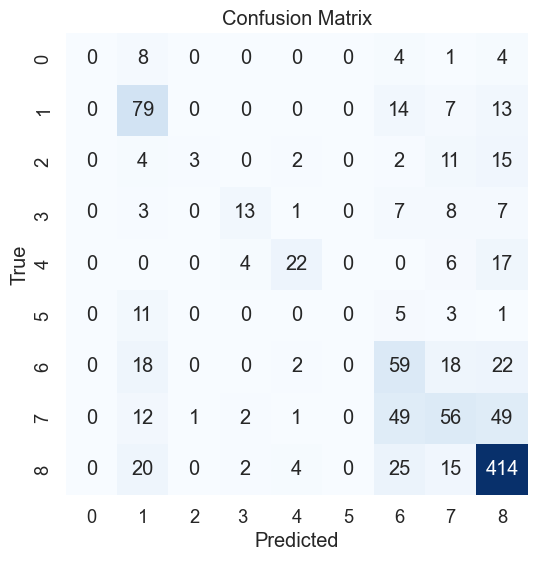

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

pred = []
for v, y in zip(val_texts, val_labels.numpy().tolist()):
    print(predict_category(v), "true: ", y)
    pred.append(predict_category(v))


confusion = confusion_matrix(val_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["0", "1", "2", "3 ", "4", "5", "6",  "7", "8"], yticklabels=["0", "1", "2", "3 ", "4", "5", "6",  "7", "8"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(val_labels, pred)
print('Accuracy:', accuracy)


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(val_labels, pred, average='weighted')
recall = recall_score(val_labels, pred, average='weighted')
f1 = f1_score(val_labels, pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

Accuracy: 0.6187739463601533
Precision: 0.6020378228947637
Recall: 0.6187739463601533
F1-Score: 0.5923581379814531


c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
save_directory = r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\data\jiujitsu\JitsuPEER_data_and_models_v1\models\roberta-base_neg" 


In [ ]:

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

In [ ]:
## ROBERTA 

In [46]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained(save_directory, from_pt=True)
model = TFRobertaForSequenceClassification.from_pretrained(save_directory, from_pt=True)




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

def predict_category(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    outputs = model(inputs)
    logits = outputs.logits
    prediction_value = tf.argmax(logits, axis=1).numpy()[0]
    return prediction_value


In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

pred = []
for v, y in zip(val_texts, val_labels.numpy().tolist()):
    print(predict_category(v), "true: ", y)
    pred.append(predict_category(v))

confusion = confusion_matrix(val_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["0", "1", "2", "3", "4", "5", "6", "7", "8"],
            yticklabels=["0", "1", "2", "3", "4", "5", "6", "7", "8"])
plt.xlabel('Vorhergesagt')
plt.ylabel('Wahr')
plt.title('Konfusionsmatrix')
plt.show()



0 true:  3
0 true:  7
0 true:  4
0 true:  0
0 true:  1
0 true:  1
0 true:  7
0 true:  7
0 true:  8
0 true:  7
0 true:  6
0 true:  8
0 true:  8
0 true:  7
0 true:  0
0 true:  8
0 true:  8
0 true:  6
0 true:  8
0 true:  8
0 true:  4
0 true:  8
0 true:  8
0 true:  8
0 true:  4
0 true:  7
0 true:  8
0 true:  8
0 true:  6
0 true:  7
0 true:  1
0 true:  2
0 true:  6
0 true:  6
0 true:  8
0 true:  6
0 true:  1
0 true:  7
0 true:  8
0 true:  8
0 true:  1
0 true:  6
0 true:  7
0 true:  1
0 true:  6
0 true:  2
0 true:  7
0 true:  1
0 true:  8
0 true:  8
0 true:  1
0 true:  8
0 true:  8
0 true:  7
0 true:  2
0 true:  6
0 true:  8
0 true:  8
0 true:  6
0 true:  8
0 true:  6
0 true:  8
0 true:  8
0 true:  8
0 true:  8
0 true:  1
0 true:  8
0 true:  8
0 true:  7
0 true:  3
0 true:  8
0 true:  8
0 true:  8
0 true:  8
0 true:  2
0 true:  8
0 true:  8
0 true:  1
0 true:  1
0 true:  1
0 true:  1
0 true:  7
0 true:  4
0 true:  1
0 true:  6
0 true:  8
0 true:  1
0 true:  6
0 true:  8
0 true:  1
0 true:  6

KeyboardInterrupt: 